In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt

In [ ]:
!pip install -U tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 27.1 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.16.2 which is incompatible.


In [ ]:
PATH = '/content/drive/MyDrive/pix2pix/'

In [ ]:

BATCH_SIZE = 1
IMG_WIDTH = 512
IMG_HEIGHT = 512

In [ ]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_png(image)

  w = tf.shape(image)[1]

  w = w //2
  input_image = image[:, :w, :]
  real_image = image[:, w:, :]


  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image



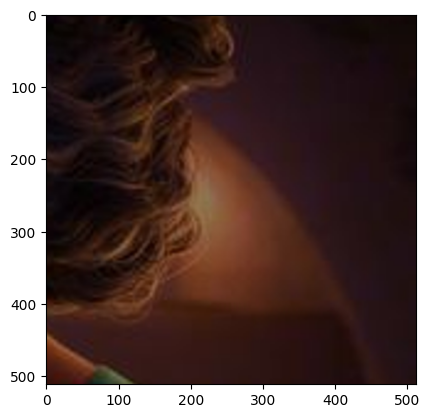

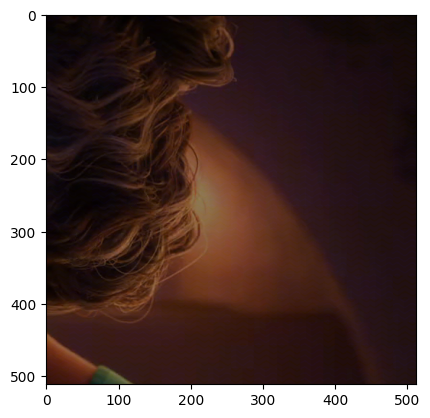

In [ ]:
inp, re = load(PATH + 'train_merged/202.png')
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [ ]:
def resize(input_image,real_image, height, width):
  input_image = tf.image.resize(input_image, [height,width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height,width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return input_image, real_image

In [ ]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image,real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
  return cropped_image[0], cropped_image[1]

In [ ]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [ ]:

@tf.function()
def random_jitter(input_image, real_image):
  input_image, real_image = resize(input_image, real_image, 572,572)

  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

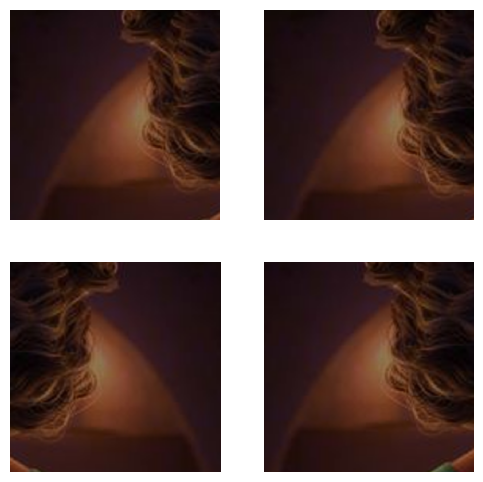

In [ ]:
plt.figure(figsize=(6,6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp,re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

In [ ]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image,real_image)

  return input_image, real_image

In [ ]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
train_dataset = tf.data.Dataset.list_files(PATH + 'train_merged/*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)


In [ ]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None))>

In [ ]:
test_dataset = tf.data.Dataset.list_files(PATH + 'test_merge/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, None), dtype=tf.float32, name=None))>

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0.,0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias = False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


In [ ]:
down_model = downsample(3,4)
down_result = down_model(tf.expand_dims(inp,0))
print(down_result.shape)

(1, 256, 256, 3)


In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0.,0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding = 'same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.LeakyReLU())

  return result



In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 512, 512, 3)


In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[512,512,3])

  down_stack = [
      downsample(128, 4, apply_batchnorm=False),
      downsample(256, 4),
      downsample(512, 4),
      downsample(1024, 4),
      downsample(1024, 4),
      downsample(1024, 4),
      downsample(1024, 4),
      downsample(1024, 4),

  ]

  up_stack = [
      upsample(1024,4,apply_dropout=True),
      upsample(1024,4,apply_dropout=True),
      upsample(1024,4,apply_dropout=True),
      upsample(1024,4),
      upsample(512,4),
      upsample(256,4),
      upsample(128,4),
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')

  x = inputs

  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)


  skips = reversed(skips[:-1])


  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)



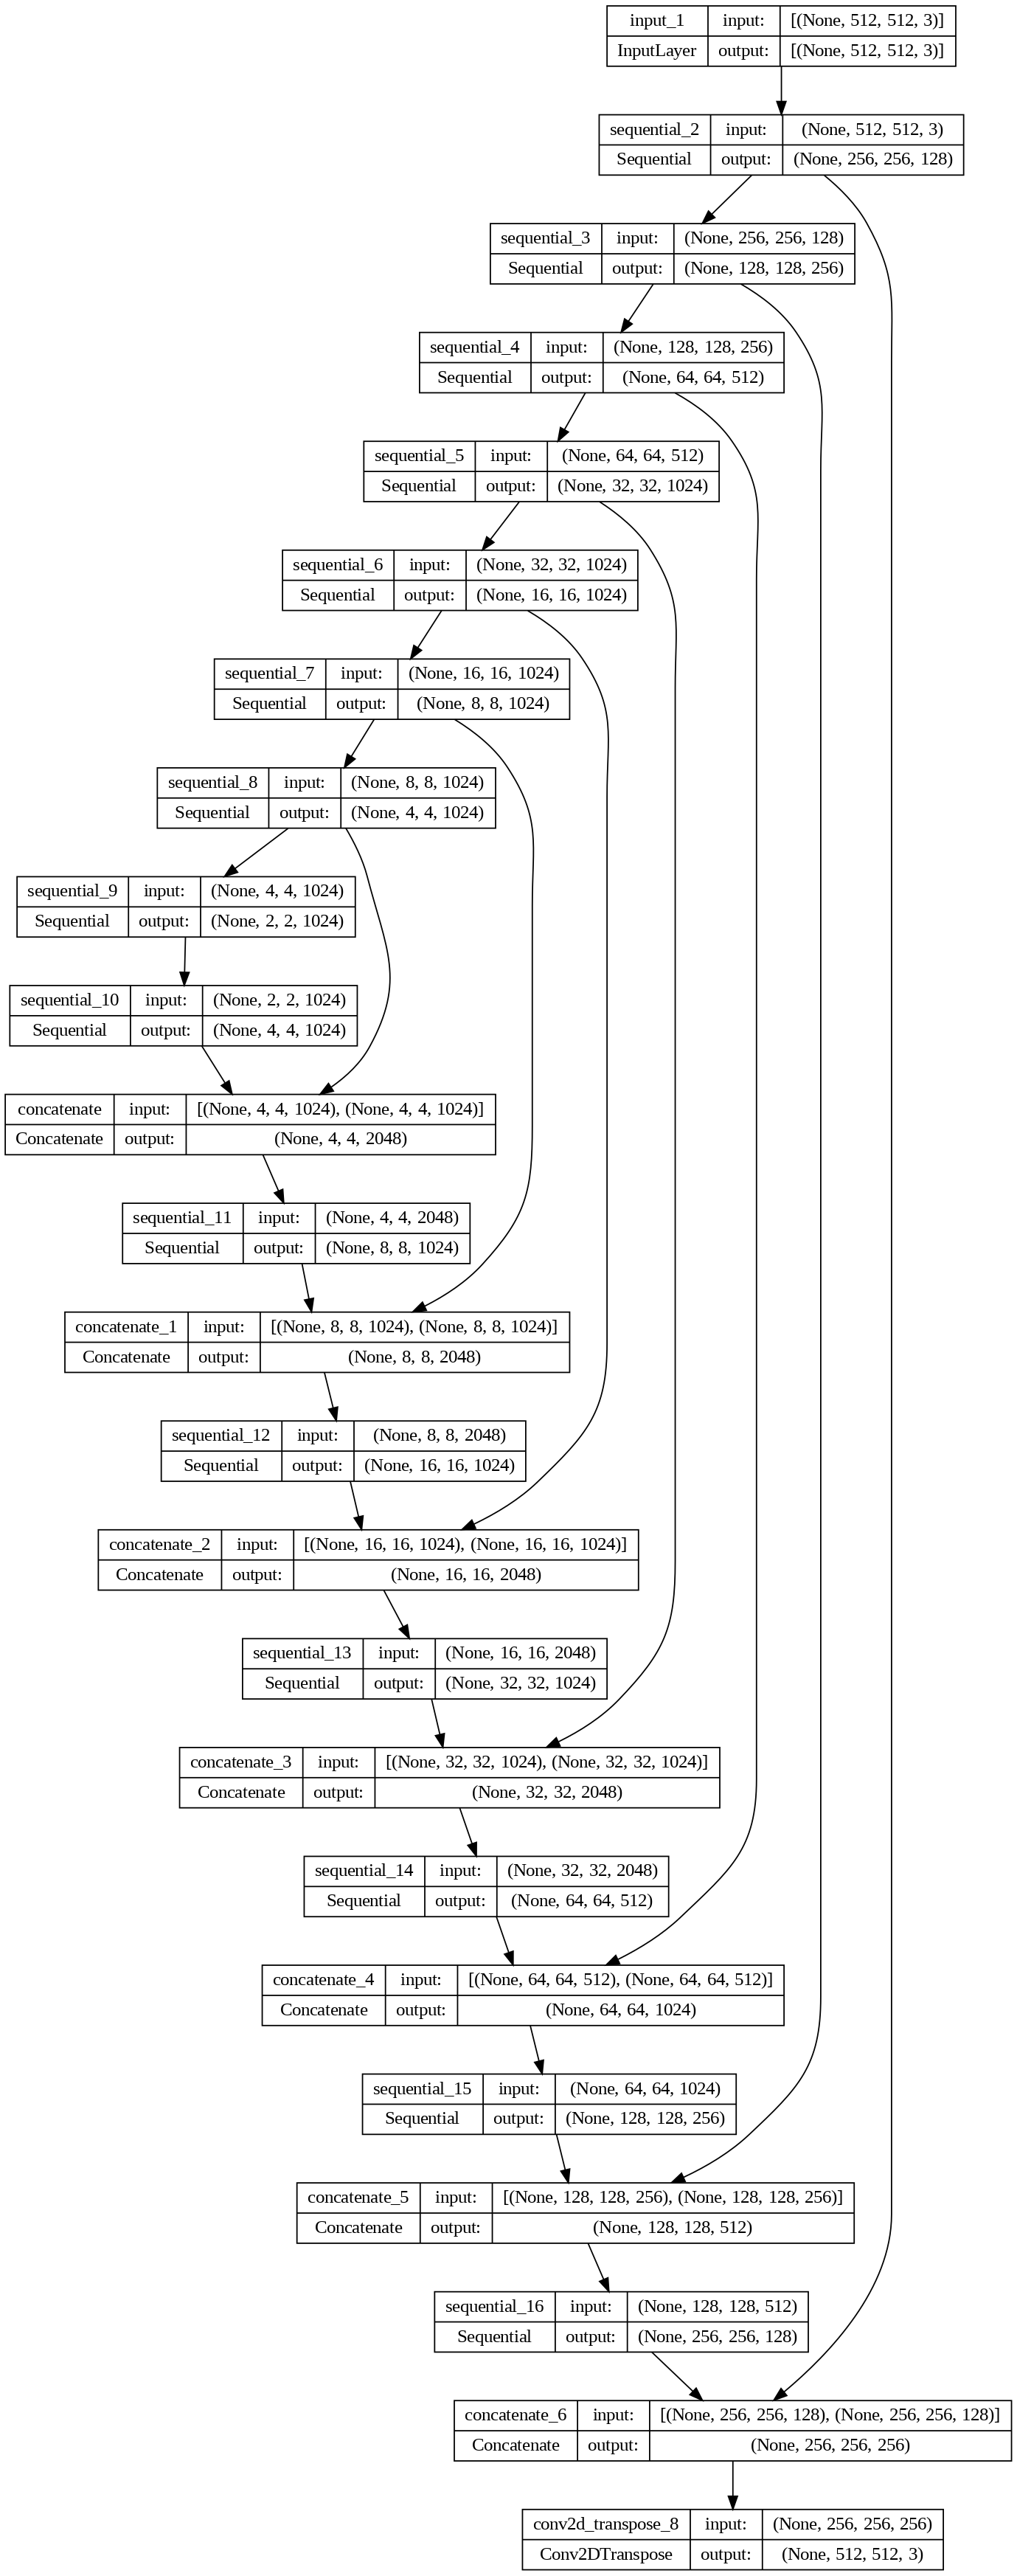

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=128)

In [ ]:
LAMBDA = 100

In [ ]:
def generator_loss (disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  return total_gen_loss, gan_loss, l1_loss

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0.,0.02)

  inp = tf.keras.layers.Input(shape=[512,512,3], name = 'input_image')
  tar = tf.keras.layers.Input(shape=[512,512,3], name='target_image')

  x = tf.keras.layers.concatenate([inp,tar])

  down1 = downsample(128, 4, False)(x)
  down2 = downsample(256, 4)(down1)
  down3 = downsample(512, 4)(down2)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
  conv = tf.keras.layers.Conv2D(1024,4, strides=1,
                                kernel_initializer= initializer,
                                use_bias=False)(zero_pad1)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

  last = tf.keras.layers.Conv2D(1,4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

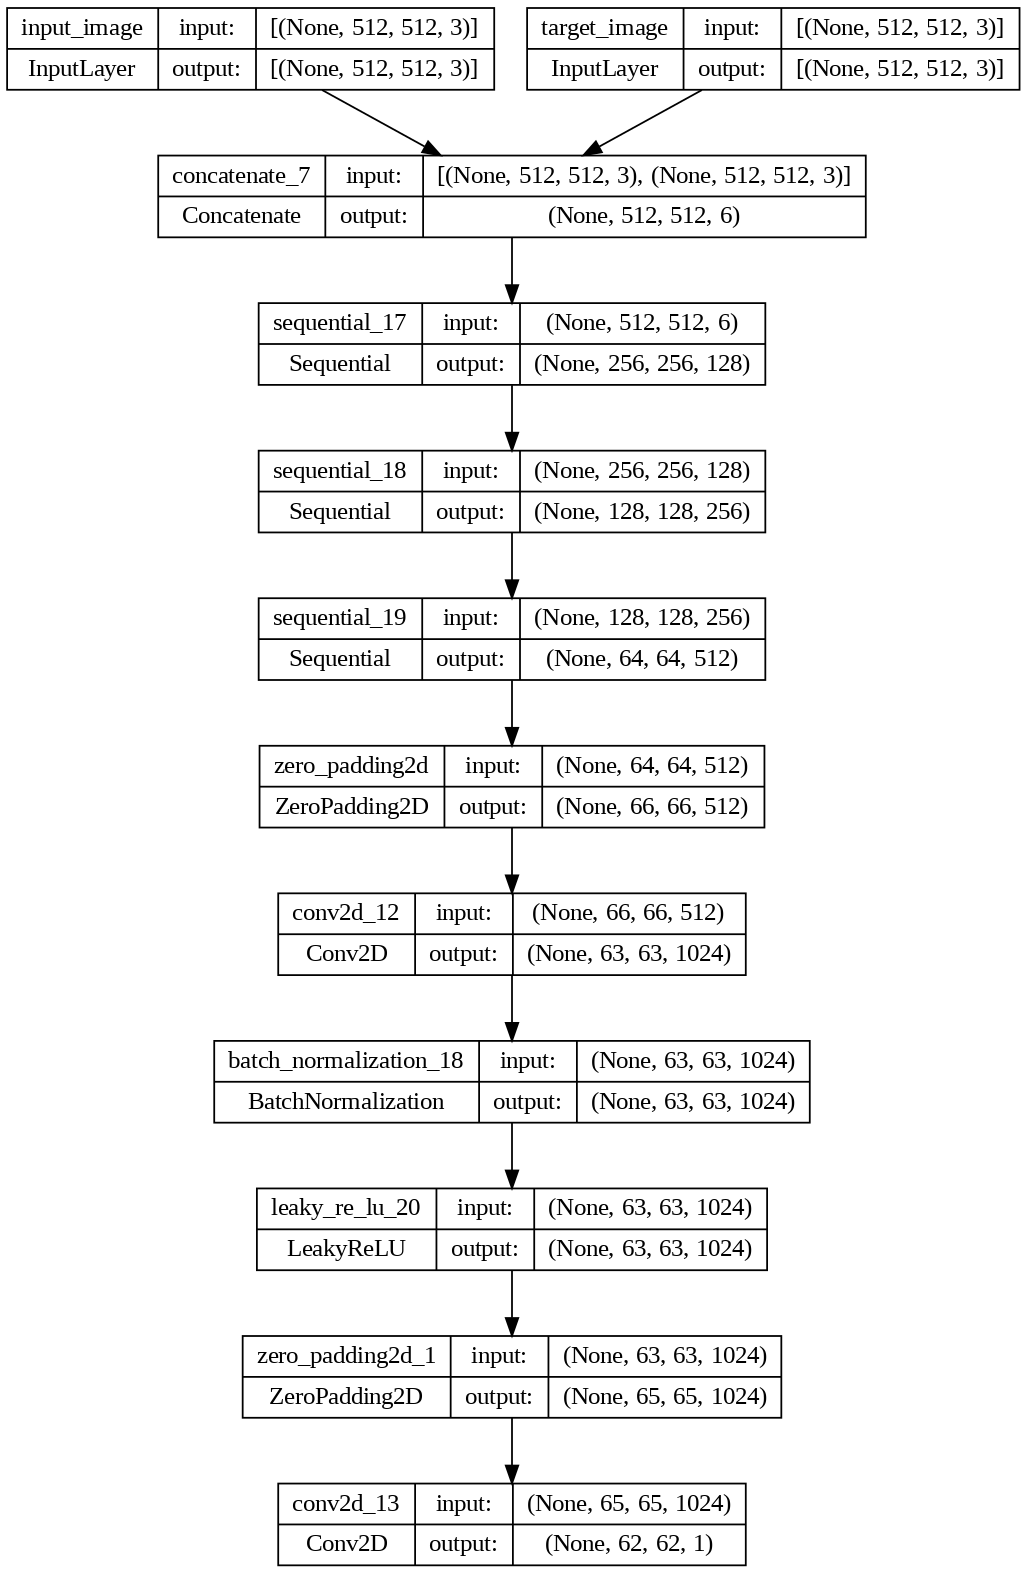

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes = True, dpi = 128)

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/UnetGAN'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator=generator,
                                 discriminator = discriminator)

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1,3,i + 1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

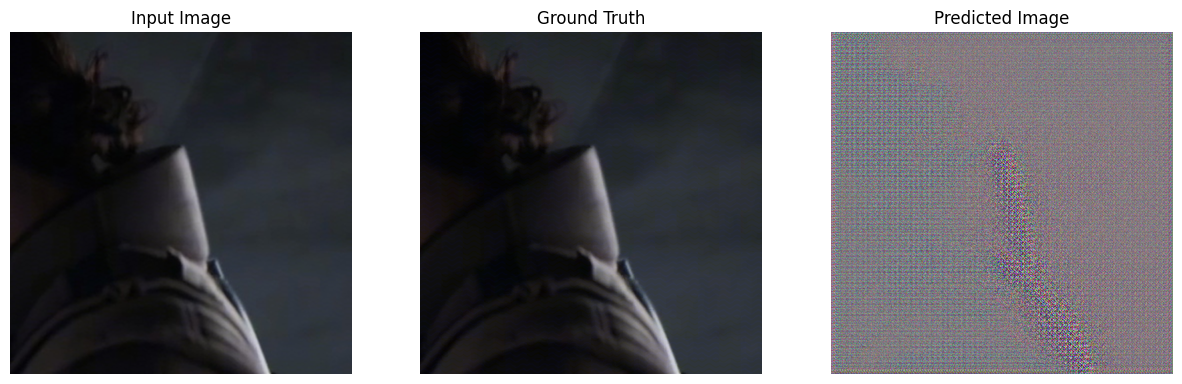

In [ ]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [ ]:
EPOCHS = 500

In [ ]:
import datetime
log_dir = "logs/"

summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function

def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)

  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))

  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                          discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)





In [ ]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time() - start))


  checkpoint.save(file_prefix = checkpoint_prefix)




In [ ]:
%reload_ext tensorboard
%tensorboard --logdir {log dir}

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2024-04-19 23:44:55.365139: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 23:44:55.365212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 23:44:55.366730: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-19 23:44:56.366105: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC] [--host ADDR]
                   [--bind_all] [--port PORT] [--reuse_port BOOL] [--load_f

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)

In [ ]:
!ls {checkpoint_dir}

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

In [ ]:
@tf.function(input_signature=[tf.TensorSpec([None,512,512,3])])
def model_predict1(input_batch):
  return{'outputs' : generator(input_batch, training=True)}

@tf.function(input_signature=[tf.TensorSpec([None,512,512,3])])
def model_predict2(input_batch):
  return{'outputs' : generator(input_batch, training=False)}


generator.save('/content/drive/MyDrive/UnetGAN/modelyo.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


In [ ]:
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter --input_format=keras /content/modelyo.h5 /content/hasilmodeljs

In [ ]:
!cp -rf hasilmodeljs /content/drive/MyDrive/Deep-Learning/image-resoration/

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/pix2pix/modelyo.h5', compile=False)

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import os
list_dir = []
list_dir = os.listdir('/content/drive/MyDrive/VRK/train_cropped')
print(list_dir)

['2883.png', '2886.png', '2884.png', '2881.png', '2887.png', '2880.png', '2882.png', '2889.png', '2892.png', '2888.png', '2890.png', '2893.png', '289.png', '2891.png', '2896.png', '2894.png', '2899.png', '2897.png', '2898.png', '2895.png', '29.png', '290.png', '2900.png', '2903.png', '2902.png', '2901.png', '2906.png', '2905.png', '2904.png', '2907.png', '2908.png', '291.png', '2913.png', '2909.png', '2912.png', '2911.png', '2910.png', '2915.png', '2916.png', '2919.png', '2917.png', '2914.png', '2918.png', '2922.png', '292.png', '2923.png', '2920.png', '2921.png', '2924.png', '2925.png', '2928.png', '2927.png', '293.png', '2931.png', '2930.png', '2929.png', '2926.png', '2932.png', '2935.png', '2934.png', '2933.png', '2936.png', '2938.png', '294.png', '2937.png', '2941.png', '2939.png', '2940.png', '2945.png', '2943.png', '2946.png', '2942.png', '2944.png', '2949.png', '2948.png', '2947.png', '2951.png', '2950.png', '295.png', '2955.png', '2957.png', '2954.png', '2956.png', '2952.png', 

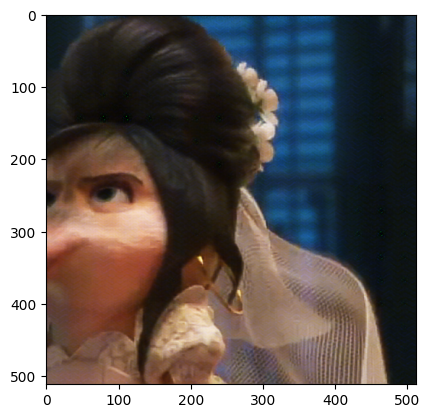

In [ ]:
for i in list_dir
  image = tf.io.read_file(f'/content/drive/MyDrive/VRK/train_cropped/{i}')
  image = tf.image.decode_png(image, channels=3)
  image = tf.image.resize(image, [512,512])
  image = tf.cast(image, tf.float32)
  image = (image / 125.5) - 1
  prediction = new_model(tf.expand_dims(image,0), training=True)
  asli = prediction[0] * 0.5 + 0.5
  plt.imshow(asli)
  pil_img = tf.keras.preprocessing.image.array_to_img(asli)
  plt.imshow(pil_img)
  pil_img.save(f'{i}')

In [ ]:
import tensorflow as tf
from PIL import Image
import argparse
import os
dir_path = os.path.dirname(os.path.realpath(__file__))


parser = argparse.ArgumentParser(description='Process for creating restoration Image')
parses.add_argument('--source_file', help='Source targer')
parses.add_argument('--target_file', help='target file')

args = parser.parse_args()

source_file = args.source_file
target_file = args.target_file

new_model = tf.keras.models.load_model(dir_path + '/modelyo.h5', compile=False)

image = tf.oi.read_file(source_file)
image = tf.image.decode_png(image, channels=3)
image = tf.image.resize(image, [512,512],
                        method=tf.image.ResizedMethod.NEAREST_NEIGHBOR)

